In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [2]:
df = pd.read_csv("../Data/ScoreSight_ML_Season_LeagueWinner_Champion.csv")

print(df.shape)
df.head()


(180, 16)


,season,team,matches_played,wins,draws,losses,points_per_game,goals_scored,goals_conceded,goal_difference,target_total_points,target_league_position,target_champion,target_top_4,target_top_6,target_relegated
0,2015-16,Bournemouth,38,11,9,18,1.105263,45.0,67.0,-22.0,42,15,0,0,0,0
1,2015-16,Norwich,38,9,7,22,0.894737,39.0,67.0,-28.0,34,19,0,0,0,1
2,2015-16,Man United,38,19,9,10,1.736842,49.0,35.0,14.0,66,4,0,1,1,0
3,2015-16,Chelsea,38,12,14,12,1.315789,59.0,53.0,6.0,50,10,0,0,0,0
4,2015-16,Everton,38,11,14,13,1.236842,59.0,55.0,4.0,47,11,0,0,0,0


In [3]:
print(df.info())
print("\nNull values per column:")
print(df.isnull().sum())

print("\nClass balance of target_champion:")
print(df["target_champion"].value_counts())
print("\nProportion:")
print(df["target_champion"].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   season                  180 non-null    object 
 1   team                    180 non-null    object 
 2   matches_played          180 non-null    int64  
 3   wins                    180 non-null    int64  
 4   draws                   180 non-null    int64  
 5   losses                  180 non-null    int64  
 6   points_per_game         180 non-null    float64
 7   goals_scored            180 non-null    float64
 8   goals_conceded          180 non-null    float64
 9   goal_difference         180 non-null    float64
 10  target_total_points     180 non-null    int64  
 11  target_league_position  180 non-null    int64  
 12  target_champion         180 non-null    int64  
 13  target_top_4            180 non-null    int64  
 14  target_top_6            180 non-null    in

In [4]:
data = df.copy()

# Drop rows where target is missing (just in case)
data = data.dropna(subset=["target_champion"])

# Define features to DROP from X
drop_cols = [
    "team",
    "season",  # we'll use later only for splitting if needed
    "matches_played",
    "target_total_points",
    "target_league_position",
    "target_top_4",
    "target_top_6",
    "target_relegated"
]

X = data.drop(columns=drop_cols, errors="ignore")

# Now separate target
y = X["target_champion"]
X = X.drop(columns=["target_champion"])

print("Feature columns being used:")
print(list(X.columns))


Feature columns being used:
['wins', 'draws', 'losses', 'points_per_game', 'goals_scored', 'goals_conceded', 'goal_difference']


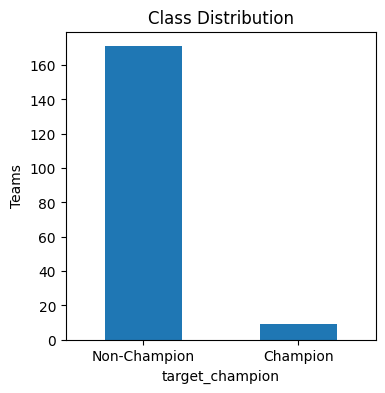

In [5]:
plt.figure(figsize=(4,4))
y.value_counts().plot(kind="bar")
plt.xticks([0,1], ["Non-Champion", "Champion"], rotation=0)
plt.title("Class Distribution")
plt.ylabel("Teams")
plt.show()


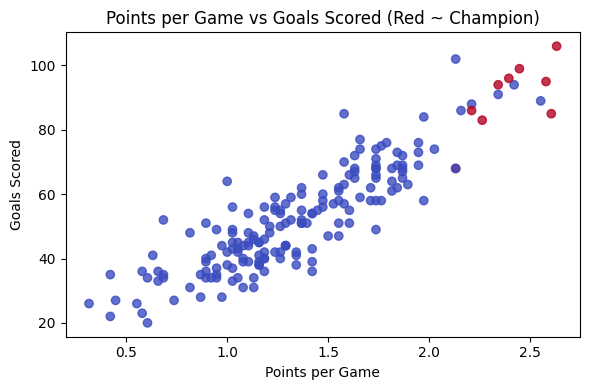

In [6]:
plt.figure(figsize=(6,4))
plt.scatter(X["points_per_game"], X["goals_scored"], c=y, cmap="coolwarm", alpha=0.8)
plt.xlabel("Points per Game")
plt.ylabel("Goals Scored")
plt.title("Points per Game vs Goals Scored (Red ~ Champion)")
plt.tight_layout()
plt.show()


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [8]:
seasons = sorted(df["season"].unique())
split_idx = int(len(seasons) * 0.7)  # 70% seasons train, 30% test
train_seasons = seasons[:split_idx]
test_seasons = seasons[split_idx:]

train_mask = df["season"].isin(train_seasons)
test_mask = df["season"].isin(test_seasons)

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print("Train seasons:", train_seasons)
print("Test seasons:", test_seasons)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train seasons: ['2015-16', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22']
Test seasons: ['2022-23', '2023-24', '2024-25']
Train shape: (120, 7)
Test shape: (60, 7)


In [9]:
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:,1]

def evaluate_classifier(name, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)

    print(f"\n=== {name} ===")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f}")
    print(f"F1-score:  {f1:.3f}")
    print(f"ROC AUC:   {auc:.3f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc
    }

results_lr = evaluate_classifier("Logistic Regression", y_test, y_pred_lr, y_proba_lr)



=== Logistic Regression ===
Accuracy:  0.933
Precision: 0.429
Recall:    1.000
F1-score:  0.600
ROC AUC:   0.988

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        57
           1       0.43      1.00      0.60         3

    accuracy                           0.93        60
   macro avg       0.71      0.96      0.78        60
weighted avg       0.97      0.93      0.95        60

Confusion matrix:
[[53  4]
 [ 0  3]]


In [10]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

results_rf = evaluate_classifier("Random Forest", y_test, y_pred_rf, y_proba_rf)



=== Random Forest ===
Accuracy:  0.967
Precision: 0.667
Recall:    0.667
F1-score:  0.667
ROC AUC:   0.988

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        57
           1       0.67      0.67      0.67         3

    accuracy                           0.97        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.97      0.97      0.97        60

Confusion matrix:
[[56  1]
 [ 1  2]]


           feature  importance
0             wins    0.212319
2           losses    0.211894
3  points_per_game    0.196054
6  goal_difference    0.171195
5   goals_conceded    0.115476
4     goals_scored    0.077754
1            draws    0.015308


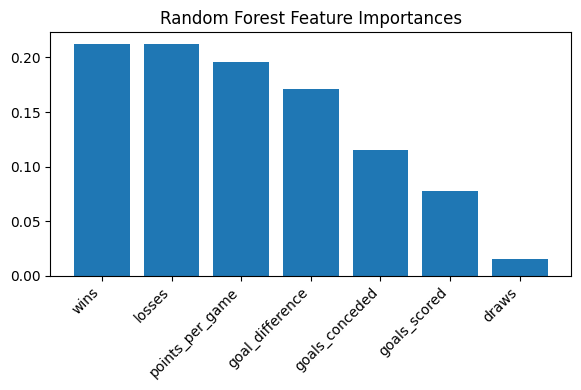

In [11]:
importances = rf.feature_importances_
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_imp)

plt.figure(figsize=(6,4))
plt.bar(feat_imp["feature"], feat_imp["importance"])
plt.xticks(rotation=45, ha="right")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()
